# NB-SVM Code Along

---

This notebook is a code along (re-implementation) of the [NB-SVM strong linear baseline](https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline) Kaggle kernel by Jeremy Howard.

Code Alongs are effective for quickly learning new material and assimilating techniques through another's thought processes. They also work well as refreshers and self-checks.

-- Wayne Nixalo 28/3/2018

## 1. Introduction

This kernel shows how to use NBSVM (Naïve Bayes - Support Vector Machine) to create a strong baseline for the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) competition. NBSVM was introduced by Sida Wang and Chris Manning in the paper [Baselines and Bigrams: Simple, Good Sentiment and Topic Classification](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf). In this kernel, we use sklearn's logistic regression, rather than SVM, although in practice the two are nearly identical (sklearn uses the liblinear library behind the scenes).

If you're not familiar with naïve bayes and bag of words matrices, I've made a preview available of one of fast.ai's upcomming *Practical Machine Learning* course videos, which introduces this topic. Here is a link to the section of the video which discusses this: [Naive Bayes video](https://youtu.be/37sFIak42Sc?t=3745).

In [1]:
%matplotlib inline

import pathlib
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
PATH = pathlib.Path('../../data/competitions/jigsaw-toxic-comment-classification-challenge')

train = pd.read_csv(PATH / 'train.csv')
test  = pd.read_csv(PATH / 'test.csv')
subm  = pd.read_csv(PATH / 'sample_submission.csv')

## Looking at the Data

The training data contains a row per comment, with an id, the text of the comment, and 6 different labels that we'll try to predict.

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Here're a couple comments, one toxic, and one with no labels:

In [4]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [5]:
train['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

The length of comments varies a lot:

Mean: 394.0732213246768  StdDev: 590.7202819048919  Max: 5000


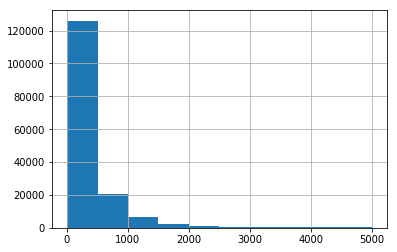

In [6]:
lens = train.comment_text.str.len()
print(f'Mean: {lens.mean()}  StdDev: {lens.std()}  Max: {lens.max()}')
lens.hist();

We'll create a list of all the labels to predict, and we'll also create a 'none' label so we can see how many comments have no labels. We can then summarize the dataset.

Adding the 'none' label works by taking 1 $-$ the max of each row. If a comment already has a label, the max will be 1 (classifications are one-hot encoded) and thus 'none' will be zero. Otherwise the max is zero (no classification label) and 'none' will be set to 1 for that row.

In [8]:
# example of first 8 rows
label_cols = list(train.columns[2:])
1 - train[label_cols][:8].max(axis=1)

0    1
1    1
2    1
3    1
4    1
5    1
6    0
7    1
dtype: int64

In [9]:
label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
train['none'] = 1 - train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
len(train), len(test)

(159571, 153164)

There are a few empty comments that we need to get rid of, otherwise sklearn will complain.

In [14]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

## Building the Model

We'll start by creating a *Bag of Words* representation, as a *Term-Document Matrix*. We'll use n-grams, as suggested in the [NBSVM paper](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf).

In [15]:
import re    ## Python regular-expressions library
import string

In [16]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s):
    return re_tok.sub(r' \1 ', s).split()

It turns out that using TF-IDF gives even better priors that the binarized features used in the paper. I don't thin kthis has been mentioned in any paper before, but it improves leaderboard score from 0.59 to 0.55.

In [17]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize, min_df=3, 
                      max_df=0.9, strip_accents='unicode', use_idf=1, 
                      smooth_idf=1, sublinear_tf=1)
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

This creates a *sparse matrix* with only a small number of non-zero elements (*stored elements* in the representation below):

In [18]:
trn_term_doc, test_term_doc

(<159571x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 17775104 stored elements in Compressed Sparse Row format>,
 <153164x426005 sparse matrix of type '<class 'numpy.float64'>'
 	with 14765755 stored elements in Compressed Sparse Row format>)

Here's the basic Naïve Bayes feature equation:

In [19]:
def pr(y_i, y):
    p = x[y == y_i].sum(0)
    return (p + 1)/((y == y_i).sum() + 1)

In [20]:
x = trn_term_doc
test_x = test_term_doc

Fit a model for one dependent at a time:

In [21]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [22]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m, r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit toxic
fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


And finally, create the submission file.

In [25]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv(PATH / 'submission.csv', index=False)

---

This scores Public / Private:

`0.9772` / `0.9761`

Which (private) ties for 3017/4551 place. Top 66% of leaderboard.

# Misc

In [7]:
# speed testing for curiosity
%timeit label_cols = [col for col in train.columns[2:]]
%timeit label_cols = list(train.columns[2:])

14 µs ± 23.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
14.6 µs ± 30.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [29]:
# 1 - train[label_cols][:10].max(axis=1)

In [30]:
# train.iloc[6]

In [31]:
# train.iloc[[5]]